In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)
pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)


In [221]:
def load_bbg_csv(path, value_candidates):
    df = pd.read_csv(path, sep=";", engine="python")

    date_col = df.columns[0]
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors="coerce")

    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    value_col = None
    for c in value_candidates:
        if c in df.columns:
            value_col = c
            break
    if value_col is None:
        raise ValueError(f"No value column found in {path}. Available columns: {list(df.columns)}")

    s = pd.to_numeric(df[value_col], errors="coerce").dropna()
    s.name = value_col
    return s

In [222]:
aapl = load_bbg_csv(
    "data/AAPL_daily_adj_20190101_today.csv",
    value_candidates=["LAST", "PX_LAST", "Close", "close", "Adj Close", "adj_close"]
).rename("aapl_close")

vix = load_bbg_csv(
    "data/VIX_daily_adj_20190101_today.csv",
    value_candidates=["PX_LAST", "LAST", "Close", "close"]
).rename("vix")

us2y = load_bbg_csv(
    "data/US2Y_daily_adj_20190101_today.csv",
    value_candidates=["PX_LAST", "LAST", "Close", "close", "yield", "Yield"]
).rename("us2y_yield")

# align on AAPL trading days
df = pd.concat([aapl, vix, us2y], axis=1).sort_index()
df[["vix", "us2y_yield"]] = df[["vix", "us2y_yield"]].ffill()

df = df.dropna()
df.head(), df.tail(), df.isna().sum()

(            aapl_close    vix  us2y_yield
 Unnamed: 0                               
 2019-01-02     39.4800  23.22      2.4676
 2019-01-03     35.5475  25.45      2.3786
 2019-01-04     37.0650  21.38      2.4937
 2019-01-07     36.9825  21.40      2.5406
 2019-01-08     37.6875  20.47      2.5855,
             aapl_close    vix  us2y_yield
 Unnamed: 0                               
 2026-01-12      260.25  15.12      3.5343
 2026-01-13      261.05  15.98      3.5324
 2026-01-14      259.96  16.75      3.5097
 2026-01-15      258.21  15.84      3.5641
 2026-01-16      255.53  15.86      3.5860,
 aapl_close    0
 vix           0
 us2y_yield    0
 dtype: int64)

In [223]:
df["ret"] = df["aapl_close"].pct_change()

# simple daily cash proxy from 2Y yield 
df["rf_daily"] = (df["us2y_yield"] / 100.0) / 252.0

df = df.dropna()
df[["aapl_close", "vix", "us2y_yield", "ret", "rf_daily"]].tail()

,aapl_close,vix,us2y_yield,ret,rf_daily
Unnamed: 0,,,,,
2026-01-12,260.25,15.12,3.5343,0.003393,0.000140
2026-01-13,261.05,15.98,3.5324,0.003074,0.000140
2026-01-14,259.96,16.75,3.5097,-0.004175,0.000139
2026-01-15,258.21,15.84,3.5641,-0.006732,0.000141
2026-01-16,255.53,15.86,3.5860,-0.010379,0.000142


In [ ]:
# --- parameters 
lookback_vol = 20   # EWMA horizon proxy
target_vol = 0.40   # 40% annual risk target
lev_cap = 1.3       # max leverage
sma_window = 20
sma_band = -0.02    # allow 2% below SMA before cutting
vix_cut = 35.0      # stress threshold
vix_width = 10.0    # smooth reduction width
cost_bps = 1.0      # 1bp per unit turnover







# --- trend filter ---
df["sma20"] = df["aapl_close"].rolling(sma_window).mean()
df["trend_ok"] = (df["aapl_close"] > (1.0 + sma_band) * df["sma20"]).astype(float)

# --- EWMA volatility forecast on daily squared returns ---
alpha = 2.0 / (lookback_vol + 1.0)  # alpha = 2/(L+1)
df["ewma_var"] = (df["ret"]**2).ewm(alpha=alpha, adjust=False).mean() #o^2_t = EWMA(r^2_t; alpha)


df["vol_hat_ann"] = np.sqrt(252.0 * df["ewma_var"]).replace(0, np.nan) #vol_hat_ann,t = sqrt(252 * o^2_t)

# volatility targeting leverage: w_raw,t = clip(target_vol / vol_hat_ann,t, 0, lev_cap)
df["w_raw"] = (target_vol / df["vol_hat_ann"]).clip(lower=0.0, upper=lev_cap).fillna(0.0)

# --- VIX overlay (smooth gate 1 -> 0 when VIX is high) ---
df["g_vix"] = (1.0 - (df["vix"] - vix_cut) / vix_width).clip(lower=0.0, upper=1.0)

# final weight: w_raw,t = clip(target_vol / vol_hat_ann,t, 0, lev_cap)
df["w"] = (df["w_raw"] * df["trend_ok"] * df["g_vix"]).clip(lower=0.0, upper=lev_cap) 



df[["w_raw", "trend_ok", "g_vix", "w"]].tail()


,w_raw,trend_ok,g_vix,w
Unnamed: 0,,,,
2026-01-12,1.3,0.0,1.0,0.0
2026-01-13,1.3,0.0,1.0,0.0
2026-01-14,1.3,0.0,1.0,0.0
2026-01-15,1.3,0.0,1.0,0.0
2026-01-16,1.3,0.0,1.0,0.0


In [225]:
w_prev = df["w"].shift(1).fillna(0.0)

# portfolio return with cash allocation (and borrowing at rf if w>1) 
# gross_t = w_prev*ret_t + (1-w_prev)*rf_daily
gross = w_prev * df["ret"] + (1.0 - w_prev) * df["rf_daily"]

turnover = (df["w"] - w_prev).abs()
cost = (cost_bps / 10000.0) * turnover

df["strat_ret"] = gross - cost
df["bh_ret"] = df["ret"]  # 100% buy&hold

df["eq_strat"] = (1.0 + df["strat_ret"]).cumprod()
df["eq_bh"] = (1.0 + df["bh_ret"]).cumprod()


In [226]:
def kpis(returns, rf=None):
    r = returns.dropna()
    if rf is None:
        rf = 0.0
        ex = r
    else:
        ex = (r - rf.loc[r.index]).dropna()

    ann_ret = (1.0 + r).prod() ** (252.0 / len(r)) - 1.0
    ann_vol = r.std() * np.sqrt(252.0)
    sharpe = (ex.mean() / r.std()) * np.sqrt(252.0) if r.std() > 0 else np.nan

    eq = (1.0 + r).cumprod()
    dd = eq / eq.cummax() - 1.0
    maxdd = dd.min()
    calmar = ann_ret / abs(maxdd) if maxdd < 0 else np.nan

    return {
        "CAGR": ann_ret,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": maxdd,
        "Calmar": calmar
    }

kpi_strat = kpis(df["strat_ret"], rf=df["rf_daily"])
kpi_bh = kpis(df["bh_ret"], rf=df["rf_daily"])

kpi_strat, kpi_bh


({'CAGR': np.float64(0.31106145324004153),
  'AnnVol': np.float64(0.2714638063809027),
  'Sharpe': np.float64(1.0368903414365762),
  'MaxDD': -0.33449045425181245,
  'Calmar': np.float64(0.9299561445955854)},
 {'CAGR': np.float64(0.3045887393542901),
  'AnnVol': np.float64(0.310053849885135),
  'Sharpe': np.float64(0.9278686627889394),
  'MaxDD': -0.3343371168249557,
  'Calmar': np.float64(0.9110228090940901)})

In [227]:
# vol-matched buy&hold
bh_vol = df["bh_ret"].std() * np.sqrt(252.0)
strat_vol = df["strat_ret"].std() * np.sqrt(252.0)

w_bh = strat_vol / bh_vol if bh_vol > 0 else 1.0
w_bh = float(np.clip(w_bh, 0.0, 3.0))

df["bh_vm_ret"] = w_bh * df["ret"] + (1.0 - w_bh) * df["rf_daily"]
df["eq_bh_vm"] = (1.0 + df["bh_vm_ret"]).cumprod()

kpi_bh_vm = kpis(df["bh_vm_ret"], rf=df["rf_daily"])
w_bh, kpi_bh_vm


(0.8755376089717037,
 {'CAGR': np.float64(0.27290261086563783),
  'AnnVol': np.float64(0.2714598438413387),
  'Sharpe': np.float64(0.9278822070252968),
  'MaxDD': -0.2972277613726374,
  'Calmar': np.float64(0.9181598973303746)})

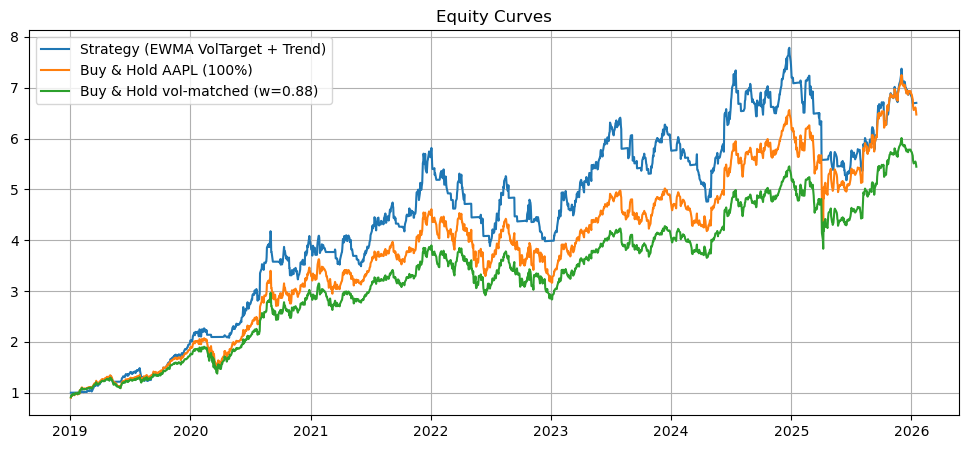

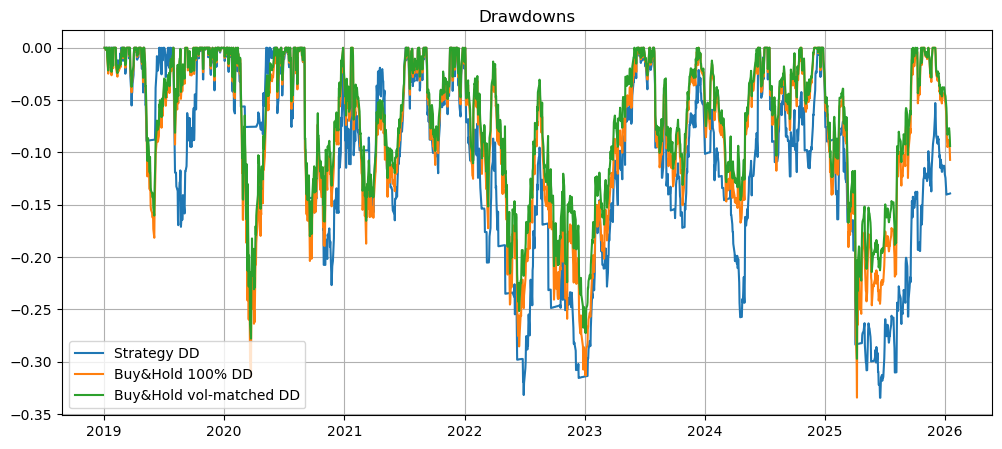

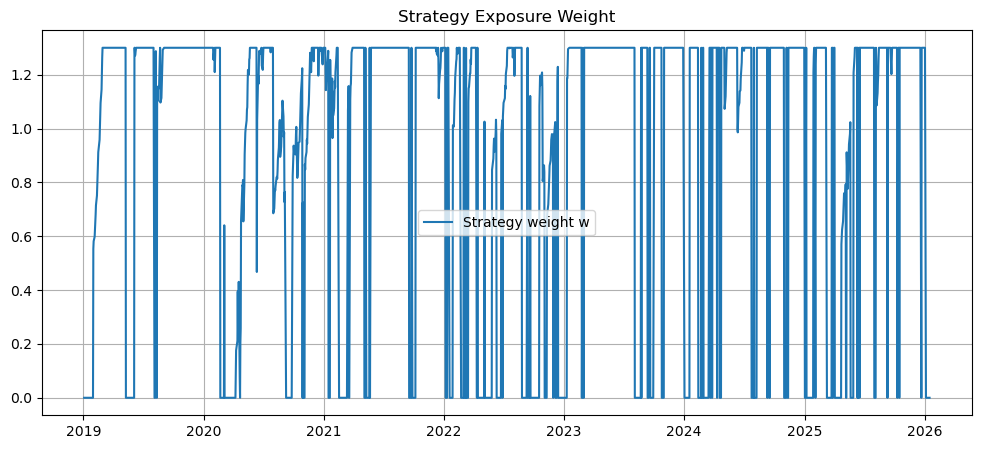

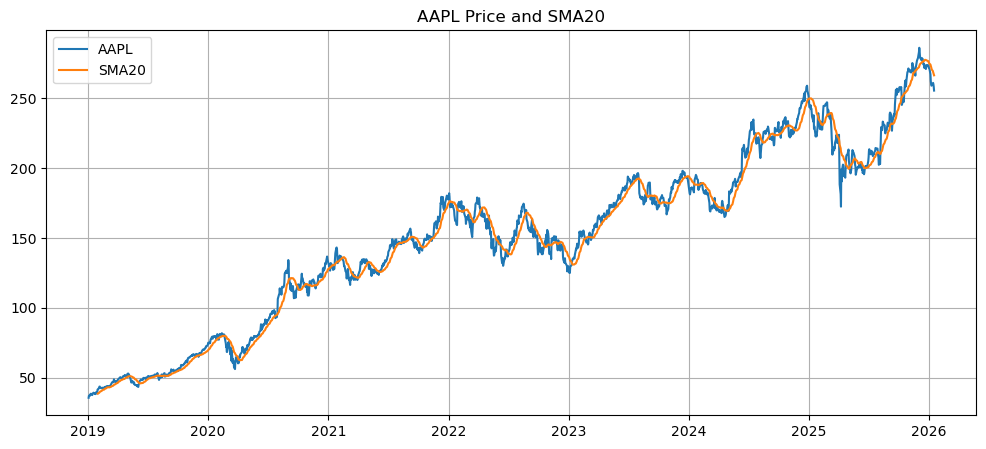

In [228]:
# Equity curves
plt.figure()
plt.plot(df.index, df["eq_strat"], label="Strategy (EWMA VolTarget + Trend)")
plt.plot(df.index, df["eq_bh"], label="Buy & Hold AAPL (100%)")
plt.plot(df.index, df["eq_bh_vm"], label=f"Buy & Hold vol-matched (w={w_bh:.2f})")
plt.title("Equity Curves")
plt.legend()
plt.grid(True)
plt.show()

# Drawdowns
def drawdown(eq):
    return eq / eq.cummax() - 1.0

plt.figure()
plt.plot(df.index, drawdown(df["eq_strat"]), label="Strategy DD")
plt.plot(df.index, drawdown(df["eq_bh"]), label="Buy&Hold 100% DD")
plt.plot(df.index, drawdown(df["eq_bh_vm"]), label="Buy&Hold vol-matched DD")
plt.title("Drawdowns")
plt.legend()
plt.grid(True)
plt.show()

# Weight / signal
plt.figure()
plt.plot(df.index, df["w"], label="Strategy weight w")
plt.title("Strategy Exposure Weight")
plt.legend()
plt.grid(True)
plt.show()

# Price + SMA20
plt.figure()
plt.plot(df.index, df["aapl_close"], label="AAPL")
plt.plot(df.index, df["sma20"], label="SMA20")
plt.title("AAPL Price and SMA20")
plt.legend()
plt.grid(True)
plt.show()
